In [94]:
import os
import re
from dotenv import load_dotenv
from openai import OpenAI
from datasets import load_dataset # hugging face, I think

from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

Since lesson six on reward hacking is really just a continued extension of the transcript and summary example problem defined and worked through in lesson five, I'll do lesson five and lesson six in this same notebook.

# Lesson five: Reward functions with LLM-as-a-judge

While most of the lectures are either totally general (the intro ones) or specific to solving Wordle (like lessons three and four), this one is specific but not to Wordle. It's interesting as a good way to think about different kinds of rewards, and especially to places where it's harder to quantify 'good' and 'bad' than something like a game or code (i.e., where things aren't verifiable directly/objectively).

In [8]:
_ = load_dotenv(override=True) # populate env from .env file, reload of file - 'override' - ok here

MODEL_NAME='predibase/Meta-Llama-3.1-8B-Instruct-dequantized'

# the examples use both OpenAI's API and Predibase's API.
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

pb_client = OpenAI(
    base_url=os.environ['PREDIBASE_LLAMA_MODEL_URL'],
    api_key=os.environ['PREDIBASE_API_TOKEN']
)

## Load earnings call data and use Predibase API to get summaries

In [9]:
ds = load_dataset('mrSoul7766/ECTSum')
transcript = ds['train'][1]['text']
print(transcript[:1983])

I'm joined by Tom Greco, our President and Chief Executive Officer; and Jeff Shepherd, our Executive Vice President and Chief Financial Officer.
We also hope that you and your families are healthy and safe.
The health and safety of our team members and customers has been a top priority over the past year.
With strength across all channels, we delivered comparable store sales growth of 24.7%, and margin expansion of 478 basis points versus the prior year.
On a two-year stack, our comp sales growth was 15.4%.
Adjusted diluted earnings per share of $3.34 represented an all-time quarterly high for AAP, and improved more than 230% compared to Q1 2020.
Free cash flow of $259 million was up significantly versus the prior year, and we returned over $203 million to our shareholders through a combination of share repurchases and our quarterly cash dividend.
In addition, we recently announced an updated capital allocation framework targeting top quartile total shareholder return, highlighted by o

In [64]:
len(transcript)

21810

The above is a transcript of an earnings call. Suppose for this example notebook, what we want is a good summary of the call w/ the key takeaways, and no hallucinations.

In [10]:
SUMMARIZE_PROMPT = """Generate a concise summary of the information in the following earnings call transcript.

Only respond with the summary, do not include any extraneous text.

Transcript:

{transcript}
"""

In [11]:
def summarize(transcript, n=1):
    prompt = SUMMARIZE_PROMPT.format(transcript=transcript)
    messages = [
        {'role': 'user', 'content': prompt},
    ]

    return pb_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
        n=n,
        temperature=0.9,
    )

resp = summarize(transcript)
summary = resp.choices[0].message.content
print(summary)

Advance Auto Parts reported Q1 2021 results:

* Comparable store sales growth of 24.7%
* Margin expansion of 478 basis points
* Adjusted diluted earnings per share of $3.34, up 230% from Q1 2020
* Free cash flow of $259 million
* Returned $203 million to shareholders through share repurchases and dividend
* Raised comp sales guidance to up 4-6%
* Updated adjusted OI margin range to 9-9.2%
* Confident in long-term strategic plans to deliver strong and sustainable total shareholder return


Interestingly, the summary I get above is much shorter (the requested 'conciseness') than the one that the lecture shows. I think I'm using the same model, but perhaps something else's changed? (Side question: if we're doing this RFT work here to 'get better summaries' and models already summarize well, especially given good prompts, and new and/or bigger models probably summarize even better, this points to wanting metrics to judge how our RFT work improves, and how it compares to existing and new models. Maybe some of the reward function work here is useful when thinking about that too, or is that 'teaching to the test' and would we want something separate?)

## Use a separate LLM as a judge of the quality of the summary

Above we used a Predibase-hosted Llama-3.1-8B model to generate a summary. Here we'll use a separate GPT-4o-mini model, via OpenAI directly, to assign a reward score to a summary. That is, we're using the second LLM as a cheaper/faster replacement for having an SME judge and rate the quality of the summary.

In [12]:
JUDGE_PROMPT_V1 = """
Rate the following summary of an earnings call transcript on a 
scale from 1 to 10. 

1 means the summary is very poor, 10 means the summary is very good.

Provide reasoning followed by the final score at the end 
surrounded by <score> tags.

For example:

<score>1</score>

Transcript:

{transcript}

Summary:

{summary}
"""

In [15]:
def judge_reward_v1(
    transcript: str,
    summary: str,
    model: str = 'gpt-4o-mini',
    verbose: bool = False
) -> float:
    prompt = JUDGE_PROMPT_V1.format(transcript=transcript, summary=summary)
    messages = [ { 'role': 'user', 'content': prompt } ]

    resp = client.chat.completions.create(
        model=model,
        messages=messages,
        n=1,
        temperature=0, # get the most likely (and deterministic) score
    )
    completion = resp.choices[0].message.content

    if verbose:
        print(completion)

    try:
        match = re.search(r'<score>(\d+)</score>', completion)
        if match is None:
            return 0

        score = match.group(1).strip()
        score = int(score)
    except:
        score = 0

    return score / 10

In [14]:
score = judge_reward_v1(transcript, summary, verbose=True)
print(score)

The summary provided captures the key financial metrics and strategic updates from the earnings call transcript effectively. It highlights significant achievements such as the impressive comparable store sales growth, margin expansion, and the substantial increase in adjusted diluted earnings per share. Additionally, it notes the company's commitment to returning value to shareholders and updates on guidance, which are crucial for investors.

However, the summary could be improved by including more context about the factors driving these results, such as the impact of federal stimulus, changes in consumer behavior, and the company's strategic initiatives. It also lacks mention of specific categories or regions that contributed to the growth, which could provide a more comprehensive view of the company's performance.

Overall, while the summary is concise and covers the essential points, it misses some of the nuances and details that would give a fuller picture of the earnings call. The

Now, eight separate summaries, with a score for each.

In [16]:
resp = summarize(transcript, n=8)
summaries = [choice.message.content for choice in resp.choices]

In [17]:
scores = [judge_reward_v1(transcript, summary) for summary in summaries]
scores

[0.8, 0.7, 0.8, 0.8, 0.8, 0.7, 0.8, 0.8]

LLMs-as-a-judge have the problem we see above where we have little diversity - no 'this is really bad' or 'this is really good', which apparently is common when using this approach.

## Using LLM-generated quizzes to obtain a reward score 

Here we'll implement a different approach to hopefully get rewards w/ more diversity. We'll give one LLM the full transcript and have it generate a multiple-choice quiz of 'important' questions using the full set of information. Then we'll have a different LLM, using only the generated summaries that we want to evaluate, take the quiz. If the summary is good, the LLM should be able to do better on the quiz.

Nuts-and-bolts, we'll use structured output and pydantic to represent the generated quiz, which'll make it easier to have the other LLM 'take the quiz' (easier than something like having to parse out questions from a generated quiz in full prose/text). 

In [22]:
from pydantic import BaseModel
from random import shuffle

QUIZ_PROMPT = """
Generate a multiple-choice quiz based on the information 
in the following earnings call transcript.

Example:

```
1. What was the q1 adjusted earnings per share?
a) $3.34
b) $5.32
c) $2.49
d) $7.78

2. By what percent did same store sales rise in q1?
a) 29.4%
b) 32.1%
c) 24.7%
d) 21.2%

===== ANSWERS =====
1. a
2. c
```

Limit the length of the quiz to the top 10 most relevant questions for financial analysts.

Transcript:

{transcript}
"""

In [26]:
class Question(BaseModel):
    text: str
    options: list[str]
    answer: int

    def shuffle_options(self) -> None: 
        # LLMs like to pick particular answers more often - the second option it sounds like - so we'll shuffle them up
        correct = self.options[self.answer]

        shuffled = self.options.copy()
        shuffle(shuffled)

        self.options = shuffled
        self.answer = shuffled.index(correct)

    def __str__(self) -> str:
        output = [self.text]
        for i, option in enumerate(self.options):
            output.append(f'{chr(65+i)}. {option}')
        return '\n'.join(output)

class Quiz(BaseModel):
    questions: list[Question]

    def shuffle_all_questions(self) -> None:
        for question in self.questions:
            question.shuffle_options()

    def __str__(self) -> str:
        output = []
        for i, question in enumerate(self.questions):
            output.append(f'\nQuestion {i}:')
            output.append(str(question))
        return '\n'.join(output)

def create_quiz(transcript: str):
    prompt = QUIZ_PROMPT.format(transcript=transcript)
    messages = [ {'role': 'user', 'content': prompt} ]
    resp = client.beta.chat.completions.parse(
        model='gpt-4o-mini',
        messages=messages,
        temperature=0.7,
        response_format=Quiz,
    )

    quiz = resp.choices[0].message.parsed
    quiz.shuffle_all_questions()

    return quiz

In [27]:
quiz = create_quiz(transcript)
print(quiz)


Question 0:
What was the Q1 adjusted earnings per share reported by AAP?
A. $1.00
B. $3.34
C. $1.50
D. $2.49

Question 1:
By what percent did comparable store sales grow in Q1?
A. 24.7%
B. 32.1%
C. 15.4%
D. 29.4%

Question 2:
What was the increase in free cash flow compared to the prior year?
A. $330 million
B. $150 million
C. $200 million
D. $400 million

Question 3:
What was the company's adjusted operating income for Q1?
A. $299 million
B. $400 million
C. $250 million
D. $113 million

Question 4:
How much did AAP return to shareholders in Q1 through share repurchases and dividends?
A. $300 million
B. $250 million
C. $150 million
D. $203 million

Question 5:
What was the adjusted OI margin for Q1?
A. 9%
B. 8.5%
C. 10%
D. 7%

Question 6:
What is the target for the number of new stores AAP plans to open in 2021?
A. 200 to 250
B. 75 to 100
C. 50 to 75
D. 100 to 115

Question 7:
By how many basis points did the adjusted gross profit margin expand in Q1?
A. 50 basis points
B. 100 basis p

In [29]:
len(quiz.questions)

10

In [30]:
quiz.questions[0]

Question(text='What was the Q1 adjusted earnings per share reported by AAP?', options=['$1.00', '$3.34', '$1.50', '$2.49'], answer=1)

In [31]:
print(quiz.questions[0])

What was the Q1 adjusted earnings per share reported by AAP?
A. $1.00
B. $3.34
C. $1.50
D. $2.49


In [32]:
[question.answer for question in quiz.questions]

[1, 0, 0, 0, 3, 0, 3, 3, 1, 2]

Ok, the above generates a quiz using the transcript.

There's a comment in the lesson asking how we can be sure that the answers the LLM generates above for the quiz are actually the correct answers. The answer he gives is to have an LLM take the quiz using the full transcript (instead of using a summary as below) and discard/not use any of the questions where the answers above are different from what the LLM answers given the quiz and the full transcript. Not done/shown here - for this demo I just assume all of the generated answers are correct.

Now, we want to have an LLM take the quiz using only the generated summary that we want to evaluate.

In [33]:
letter_to_index = {"A": 0, "B": 1, "C": 2, "D": 3}
index_to_letter = ["A", "B", "C", "D"]

TAKE_QUIZ_PROMPT = """Use the provided summary of a transcript 
to answer the following quiz.

Quiz:

{quiz}

Summary:

{summary}

Respond with just a list of answers and no additional text, 
for example:

[A, D, C, B, B, C, D, A, A, B]

You must provide an answer for all 10 questions. 
If you don't know the answer, answer with "0" for that question. 
Example:

[A, D, 0, B, B, C, D, A, A, B]
"""

In [39]:
def take_quiz(summary, quiz):
    question_strs = []
    for question in quiz.questions:
        question_str = question.text
        for i, option in enumerate(question.options):
            letter = index_to_letter[i]
            question_str += f'\n{letter}. {option}'
        question_strs.append(question_str)
    quiz_str = '\n\n'.join(question_strs)

    prompt = TAKE_QUIZ_PROMPT.format(quiz=quiz_str, summary=summary)

    resp = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[ { 'role': 'user', 'content': prompt } ],
        temperature=0,
    )
    resp_str = resp.choices[0].message.content

    # convert str repr of the list to actual list of strs
    answers = resp_str.strip('[]').split(', ')

    return answers

In [41]:
answers = take_quiz(summaries[0], quiz)
answers

['B', 'A', '0', '0', 'B', 'A', '0', 'A', '0', '0']

And now we can calc the proportion of correct answers.

In [42]:
def score_quiz_answers(answers, quiz):
    assert len(answers) == len(quiz.questions)

    total = len(answers)
    correct = 0
    for answer, question in zip(answers, quiz.questions):
        expected_answer = index_to_letter[question.answer]
        if answer == expected_answer:
            correct += 1
    return correct / total

In [43]:
score_quiz_answers(answers, quiz)

0.3

In [50]:
(answers, [index_to_letter[question.answer] for question in quiz.questions])

(['B', 'A', '0', '0', 'B', 'A', '0', 'A', '0', '0'],
 ['B', 'A', 'A', 'A', 'D', 'A', 'D', 'D', 'B', 'C'])

And, now, using the proportion correct as the reward, we can generate the corresponding advantages, for the eight candidate summaries generated at the top.

In [56]:
# this pulled in from utils.py
def compute_advantages(rewards: list):
    rewards = np.array(rewards)
    
    # Compute the mean and standard deviation of the rewards
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    # Avoid division by zero in case of zero variance (typically happens when all rewards are 0)
    if std_reward == 0:
        return [0] * len(rewards)

    # Divide by stddev of rewards to normalize range to 0
    advantages = (rewards - mean_reward) / std_reward
    return advantages.tolist()

In [52]:
def print_quiz_table(all_answers, rewards):
    advantages = compute_advantages(rewards)
    length = len(all_answers)
    elems = list(zip(range(length), rewards, advantages))

    headers = ['Index', 'Reward', 'Advantage']
    table = tabulate(elems, headers=headers, tablefmt='grid').split('\n')
    for row in table:
        print(row)

In [53]:
all_answers = []
quiz_rewards = []
for summary in summaries:
    answers = take_quiz(summary, quiz)
    all_answers.append(answers)
    quiz_rewards.append(score_quiz_answers(answers, quiz))

In [57]:
print_quiz_table(all_answers, quiz_rewards)

+---------+----------+-------------+
|   Index |   Reward |   Advantage |
+=========+==========+=============+
|       0 |      0.4 |   -1.13389  |
+---------+----------+-------------+
|       1 |      0.5 |    0.377964 |
+---------+----------+-------------+
|       2 |      0.5 |    0.377964 |
+---------+----------+-------------+
|       3 |      0.4 |   -1.13389  |
+---------+----------+-------------+
|       4 |      0.6 |    1.88982  |
+---------+----------+-------------+
|       5 |      0.5 |    0.377964 |
+---------+----------+-------------+
|       6 |      0.4 |   -1.13389  |
+---------+----------+-------------+
|       7 |      0.5 |    0.377964 |
+---------+----------+-------------+


The lecture stops here... in practice, as I'll do w/ lecture six+ for Wordle, we'd use the rewards/advantages to fine-tune a model and guide it to generate summaries that lead to more questions correctly answered. I think generally we change up the actual stuff the LLMs generate to match whatever business problem we're solving, and change up how we generate the rewards so we get good diversity, and then the rest of the training process is the same.

# Lesson six: Reward hacking (still using the transcripts/summaries example from lecture five)

First off, what score does the LLM get on the quiz if they have the full transcript, not just a summary?

In [60]:
def quiz_reward(response: str, quiz: Quiz) -> float:
    """Given a summary in 'response' as context (or the transcript for the ideal), have an LLM take the quiz. 
    Better summaries should enable the model to do better on the quiz."""
    answers = take_quiz(response, quiz)
    return score_quiz_answers(answers, quiz)

In [66]:
transcript_score = quiz_reward(transcript, quiz)
transcript_score

0.7

In the lecture, they get a score of 1.0, which I think I'd expect at least naively, since LLMs do a decent job of answering questions when given the info in recent context. I do get a higher score generally than w/ the summaries, but not 100% - maybe there's something w/ the particular quiz questions that are off (i.e., if the 'correct' answer in the quiz isn't actually correct, the model taking the quiz could be getting penalized for a 'wrong' answer even though their answer is actually correct. And/or, perhaps the model isn't that great at taking quizzes. Anyway.

In [70]:
len(transcript)

21810

In [69]:
summary_lengths = [len(summary) for summary in summaries]
summary_lengths

[1171, 817, 818, 1101, 734, 707, 1200, 750]

Part of the reason that the score is higher w/ the transcript is because longer sets of text are more likely to have more info - so an RFT-trained model would be incented to prefer longer summaries, even though the prompt says to be concise. So, we want to penalize longer models. 

Fundamentally, while the lecture uses words that make 'reward hacking' seem wrong - i.e., it's 'behaving badly', I think, etc. - I don't view it that way... it's actually just telling us our metrics don't capture everything that's important, and that's on us. 

In [86]:
def length_penalty_reward(response: str) -> float:
    length = len(response)
    target_length = 1024
    if length <= target_length:
        return 0.0 # no penalty, as length is under/equal to the target
    else:
        # linearly decrease reward as length increases beyond the target, with a max of -10
        return max(
            (target_length - length) / target_length,
            -10
        )

In [89]:
length_penalty_reward(summary[0]), length_penalty_reward(transcript), length_penalty_reward(transcript[:2000])

(0.0, -10, -0.953125)

In [90]:
# from utils.py (definitely not DRY - compare w/ print_quiz_table, for example)
def print_length_table(lengths, rewards):
    advantages = compute_advantages(rewards)
    length = len(lengths)
    elems = list(zip(range(length), lengths, rewards, advantages))

    headers = ["Index", "Length", "Reward", "Advantage"]
    table = tabulate(elems, headers=headers, tablefmt="grid").split("\n")
    for row in table:
        print(row)

In [91]:
length_rewards = [length_penalty_reward(summary) for summary in summaries]
print_length_table(summary_lengths, length_rewards)

+---------+----------+------------+-------------+
|   Index |   Length |     Reward |   Advantage |
+=========+==========+============+=============+
|       0 |     1171 | -0.143555  |   -1.398    |
+---------+----------+------------+-------------+
|       1 |      817 |  0         |    0.720619 |
+---------+----------+------------+-------------+
|       2 |      818 |  0         |    0.720619 |
+---------+----------+------------+-------------+
|       3 |     1101 | -0.0751953 |   -0.389134 |
+---------+----------+------------+-------------+
|       4 |      734 |  0         |    0.720619 |
+---------+----------+------------+-------------+
|       5 |      707 |  0         |    0.720619 |
+---------+----------+------------+-------------+
|       6 |     1200 | -0.171875  |   -1.81596  |
+---------+----------+------------+-------------+
|       7 |      750 |  0         |    0.720619 |
+---------+----------+------------+-------------+


In [92]:
def total_reward(length_reward, quiz_reward):
    return length_reward + quiz_reward

total_rewards = [
    total_reward(length_reward, quiz_reward) 
    for length_reward, quiz_reward
    in zip(length_rewards, quiz_rewards)
]
total_rewards

[0.2564453125, 0.5, 0.5, 0.3248046875, 0.6, 0.5, 0.22812500000000002, 0.5]

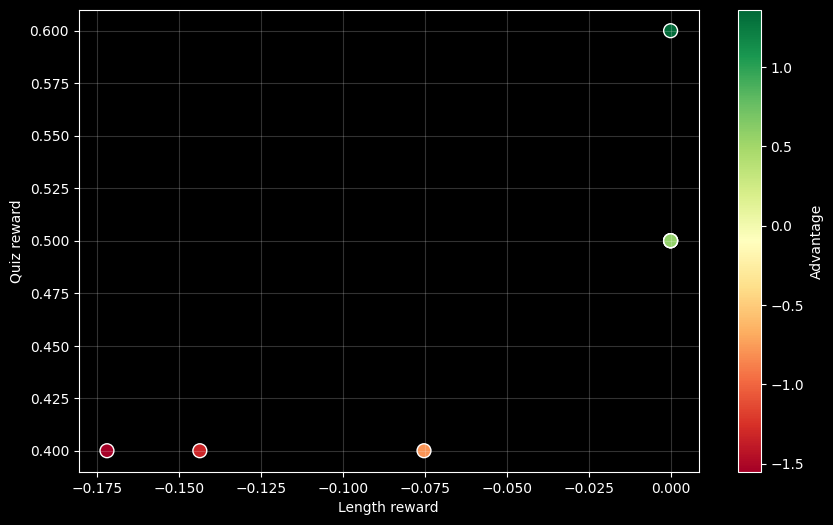

In [97]:
advantages = compute_advantages(total_rewards)
min_adv = min(advantages)
max_adv = max(advantages)

plt.figure(figsize=(10,6), facecolor='black')
plt.style.use('dark_background')
scatter = plt.scatter(length_rewards, quiz_rewards, c=advantages, cmap='RdYlGn', s=100, edgecolor='white', vmin=min_adv, vmax=max_adv)
plt.colorbar(scatter, label='Advantage')
plt.xlabel('Length reward')
plt.ylabel('Quiz reward')
plt.grid(True, alpha=0.2)

As expected, the best overall reward is where we have good quiz and length rewards (upper right); and where we have the same scores on the quiz, the shorter summaries are better. 